<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/version2/modeling/where_modeling/Other_State_Similarity_DemographicSupetSetData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

This colab is for KNN similarity 
* to find the counties from Oregon, that are similar to CA widespread counties
*  California (West-side), Wisconsin (mid-west), Texas (south central), and New York (middle Atlantic).  
* Texas(TX)-Arkansas (AR)
* New York (NY)-New Jersey (NJ)
* Wisconsin(WI) -Iowa(IA)


# Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings; warnings.simplefilter('ignore')

In [ ]:
#drive.flush_and_unmount(600000)

In [ ]:
!ls '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021'

 All_CovidDataFeb20.csv
 alldatasets_Feb20.csv
 alldatasets_Mar26.csv
 All_GoogleMobilityDataFeb20.csv
 All_SocialDistancingDataFeb20.csv
 AllStates_Superset_dataset_Feb20.csv
 AllStates_Superset_dataset_Feb21.csv
 AllStates_Superset_dataset_Mar26.csv
 CA_alldatasets_Feb05.csv
 CA_alldatasets_Jan13.csv
 CA_CombinedData_Labeled_CDCGuideline_Feb05.csv
 CA_CombinedData_Labeled_CDCGuideline_Feb06.csv
 CA_CombinedData_Labeled_CDCGuideline_Jan15.csv
 CA_combined_Feb04.csv
 CA_CovidDataJan10.csv
 CA_dataset_Feb11.csv
 CA_GoogleMobilityDataJan10.csv
 CA_MarylandData_Labeled_CDCGuideline_Feb05.csv
 CA_MarylandData_Labeled_CDCGuideline_Feb06.csv
 CA_MarylandData_Labeled_CDCGuideline_Jan15.csv
 CA_processedMarylandData_Feb04.csv
 CA_processedMarylandData_Feb05.csv
 CA_processedMarylandData_Feb12.csv
 CA_processedMarylandData_Jan11.csv
 CA_SocialDistancingDataJan10.csv
 CA_socialDistancingInertiaData_Feb04.csv
 CA_SuperData_Labeled_CDCGuideline_Feb13.csv
 CA_SuperData_Labeled_Guideline_Feb26.csv
 

# Import package

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler as ss
import itertools
from scipy import linalg
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Pipeline

In [ ]:
base_state= "Wisconsin"
similar_state= "Iowa"
similar_state_initial = 'IA'

# Load Oregon Superset Data from All states csv

In [ ]:
location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'
all_states_data = pd.read_csv(location+'AllStates_Superset_dataset_Mar26.csv', low_memory=False)
all_states_data.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k
0,2020-03-01,Alabama,1001,0,Autauga County,0.0,7.194,49,15.0,13.0,0.0,0.0,3.0,0.0,35.853419,Alabama,35,22,2.81,41.6,1.0,32.9,0.26,2.55,0,55601,-1.2,0.11,19,58786,19.0,2.8,48.68,19,101,3.79,0.33,0.025,0.0,0.0,37,47.1,0.0,0.0,0.0,0,0,0.0,28,0.4,3.5,3.2,0.3,0.0,0.0,0.0
1,2020-03-02,Alabama,1001,0,Autauga County,0.0,14.587,100,15.0,4.0,0.0,0.0,5.0,-1.0,35.853419,Alabama,11,13,3.33,40.9,0.5,42.0,0.80,2.53,0,55601,-1.9,0.11,19,58786,19.0,2.8,48.68,19,101,3.79,0.33,0.025,0.0,0.0,38,47.1,0.0,0.0,0.0,0,0,0.0,28,0.4,3.5,3.2,0.3,0.0,0.0,0.0


In [ ]:
OR_superset_data = all_states_data[all_states_data['Province_State'] == similar_state]
OR_superset_data.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k
2966,2020-03-02,Iowa,19023,0,Butler County,0.0,19.894,117,0.0,-6.0,0.0,0.0,4.0,0.0,9.806636,Iowa,14,15,3.69,39.5,0.8,54.6,0.72,2.97,0,14539,14.2,0.21,29,55999,0.5,1.3,50.09,6,143,3.69,0.26,0.011,0.0,0.0,38,30.0,0.0,0.0,0.0,0,0,0.0,21,0.8,3.7,4.8,0.5,0.0,0.0,32.665505
2967,2020-03-03,Iowa,19023,0,Butler County,0.0,16.906,100,0.0,0.0,0.0,0.0,1.0,0.0,9.806636,Iowa,11,13,3.74,41.4,0.3,57.3,0.77,2.97,0,14539,14.2,0.21,29,55999,0.5,1.3,50.09,6,143,3.69,0.26,0.011,0.0,0.0,39,30.0,0.0,0.0,0.0,0,0,0.0,28,0.8,3.7,4.8,0.5,0.0,0.0,24.680604


In [ ]:
OR_superset_data['positivity_rate'] = (OR_superset_data['New.cases.1000.people'] / OR_superset_data['Tests.done.1000.people'])* 100/1000
OR_superset_data.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate
2966,2020-03-02,Iowa,19023,0,Butler County,0.0,19.894,117,0.0,-6.0,0.0,0.0,4.0,0.0,9.806636,Iowa,14,15,3.69,39.5,0.8,54.6,0.72,2.97,0,14539,14.2,0.21,29,55999,0.5,1.3,50.09,6,143,3.69,0.26,0.011,0.0,0.0,38,30.0,0.0,0.0,0.0,0,0,0.0,21,0.8,3.7,4.8,0.5,0.0,0.0,32.665505,NaN
2967,2020-03-03,Iowa,19023,0,Butler County,0.0,16.906,100,0.0,0.0,0.0,0.0,1.0,0.0,9.806636,Iowa,11,13,3.74,41.4,0.3,57.3,0.77,2.97,0,14539,14.2,0.21,29,55999,0.5,1.3,50.09,6,143,3.69,0.26,0.011,0.0,0.0,39,30.0,0.0,0.0,0.0,0,0,0.0,28,0.8,3.7,4.8,0.5,0.0,0.0,24.680604,NaN


In [ ]:
print(OR_superset_data['County Name'].nunique())
OR_superset_data['County Name'].unique()

92


array(['Butler County', 'Calhoun County', 'Cherokee County',
       'Clarke County', 'Clay County', 'Dallas County', 'Fayette County',
       'Franklin County', 'Greene County', 'Henry County',
       'Jackson County', 'Jefferson County', 'Lee County',
       'Madison County', 'Marion County', 'Marshall County',
       'Monroe County', 'Montgomery County', 'Shelby County',
       'Washington County', 'Benton County', 'Boone County',
       'Carroll County', 'Crawford County', 'Howard County',
       'Johnson County', 'Polk County', 'Scott County', 'Union County',
       'Humboldt County', 'Fremont County', 'Hamilton County',
       'Taylor County', 'Clayton County', 'Decatur County',
       'Floyd County', 'Jasper County', 'Jones County', 'Mitchell County',
       'Worth County', 'Cass County', 'Clinton County', 'Grundy County',
       'Hancock County', 'Warren County', 'Winnebago County',
       'Delaware County', 'Harrison County', 'Adair County',
       'Allamakee County', 'Appanoos

#  Load CA Superset Labeled Data

In [ ]:
ca_labeled_superset_data = all_states_data[all_states_data['Province_State'] == base_state]
ca_labeled_superset_data.head()

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k
44512,2020-03-01,Wisconsin,55053,0,Jackson County,0.0,2.500,30,22.0,0.0,0.0,23.0,11.0,0.0,8.019932,Wisconsin,27,19,3.27,45.0,7.6,40.7,0.34,2.94,0,20478,3.2,0.13,26,52984,2.1,3.3,53.42,9,120,3.01,0.27,0.045,0.0,0.0,37,41.3,0.0,0.0,0.0,0,0,0.0,7,0.9,3.4,4.5,0.0,0.0,0.0,41.305451
44513,2020-03-02,Wisconsin,55053,0,Jackson County,0.0,8.198,99,0.0,4.0,0.0,14.0,4.0,0.0,8.019932,Wisconsin,19,18,3.44,40.1,6.1,51.1,0.53,2.91,0,20478,2.1,0.13,26,52984,2.1,3.3,53.42,9,120,3.01,0.27,0.045,0.0,0.0,38,41.3,0.0,0.0,0.0,0,0,0.0,7,0.9,3.4,4.5,0.0,0.0,0.0,35.831235
44514,2020-03-03,Wisconsin,55053,0,Jackson County,0.0,5.540,67,11.0,6.0,0.0,22.0,3.0,0.0,8.019932,Wisconsin,16,18,3.76,40.0,6.8,57.8,0.50,3.26,0,20478,14.4,0.13,26,52984,2.1,3.3,53.42,9,120,3.01,0.27,0.045,0.0,0.0,39,41.3,0.0,0.0,0.0,0,0,0.0,14,0.9,3.4,4.5,0.0,0.0,0.0,27.371082
44515,2020-03-04,Wisconsin,55053,0,Jackson County,0.0,8.236,100,10.0,2.0,0.0,6.0,4.0,0.0,8.019932,Wisconsin,14,17,3.65,38.7,7.2,57.4,0.65,3.00,0,20478,5.3,0.13,26,52984,2.1,3.3,53.42,9,120,3.01,0.27,0.045,0.0,0.0,40,41.3,5.0,0.0,0.0,0,0,0.0,14,0.9,3.4,4.5,0.0,0.0,0.0,18.413273
44516,2020-03-05,Wisconsin,55053,0,Jackson County,0.0,11.741,142,19.0,-4.0,0.0,1.0,2.0,0.0,8.019932,Wisconsin,12,16,3.55,42.6,6.6,54.9,0.58,2.97,0,20478,4.2,0.13,26,52984,2.1,3.3,53.42,9,120,3.01,0.27,0.045,0.0,0.0,41,41.3,5.0,0.0,0.0,0,0,0.0,14,0.9,3.4,4.5,0.0,0.0,0.0,12.441401


In [ ]:
ca_labeled_superset_data['Province_State'].unique()

array(['Wisconsin'], dtype=object)

In [ ]:
ca_labeled_superset_data.shape

(17862, 56)

In [ ]:
print("CA data - date range :", (ca_labeled_superset_data.Date.min(),ca_labeled_superset_data.Date.max()))
print("Oregon data - date ranges :", (OR_superset_data.Date.min(),OR_superset_data.Date.max()))

CA data - date range : ('2020-03-01', '2020-12-28')
Oregon data - date ranges : ('2020-03-01', '2020-12-28')



# Note (selected columns )

'Province_State', 'FIPS', 'County Name','PopDensity', 'State_Name','State', 'CTFIPS', 'CTNAME', 'STFIPS',
'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Employment.density','Testing.capacity', 'Ventilator.shortage','Unemployment.rate','Unemployment.claims.1000.people',

**Summary**: The latent features (loc2vec features ) describe the probalistic causal behaviour of the pandemic. The features are responsible for describing the sudden increase or surge of the pandemic. The counties with closest 

* Surge in LA -> Surge in WA county in OR


# Filter columns with Demographic features

In [ ]:
demographic_cols = [ 'FIPS', 'County Name', 'PopDensity', #'STFIPS', # remove FIPS also during knn
                 'X..people.older.than.60', 'Median.income', 
                 'X..African.Americans', 'X..Hispanic.Americans',
                  'X..Male', 'Employment.density','Testing.capacity',
                 'Ventilator.shortage','Unemployment.rate','Unemployment.claims.1000.people']

# TODO: Plot the charatertics of demographic data to represent they are similar.
* Ventilator shortage
* ICU utilization

In [ ]:
or_superset_data_filtered = OR_superset_data[demographic_cols]
ca_superset_data_filtered = ca_labeled_superset_data[demographic_cols]

# Data Analysis

In [ ]:
or_superset_data_filtered.describe().T

,count,mean,std,min,25%,50%,75%,max
FIPS,22051.0,19098.901229,56.147327,19001.000000,19049.000000,19099.000000,19149.000000,19197.000000
PopDensity,22051.0,25.268047,42.532875,4.501245,8.749441,11.534637,21.972087,320.017403
X..people.older.than.60,22051.0,26.027074,3.682039,16.000000,24.000000,26.000000,29.000000,33.000000
Median.income,22051.0,55777.930978,7200.903343,41111.000000,51043.000000,54554.000000,58803.000000,84790.000000
X..African.Americans,22051.0,1.607528,1.802651,0.000000,0.500000,0.900000,1.900000,9.000000
X..Hispanic.Americans,22051.0,5.009537,5.170692,0.700000,2.100000,2.900000,5.600000,27.800000
X..Male,22051.0,49.813628,0.812626,47.950000,49.250000,49.800000,50.290000,52.090000
Employment.density,22051.0,31.914879,64.658274,3.000000,8.000000,12.000000,24.000000,485.000000
Testing.capacity,22051.0,12.290712,4.585545,0.000000,9.400000,11.300000,15.400000,31.400000
Ventilator.shortage,22051.0,60.435445,43.003455,0.000000,31.000000,46.000000,95.000000,170.000000


In [ ]:
ca_superset_data_filtered.describe().T

,count,mean,std,min,25%,50%,75%,max
FIPS,17862.0,55072.555705,41.065994,55001.000000,55035.000000,55073.000000,55107.000000,55141.000000
PopDensity,17862.0,73.842899,197.252971,4.153341,12.236395,21.981493,60.420364,1525.658962
X..people.older.than.60,17862.0,26.061247,4.956984,18.000000,23.000000,25.000000,29.000000,40.000000
Median.income,17862.0,56894.986172,8313.017442,43280.000000,51335.000000,56268.000000,59749.000000,84331.000000
X..African.Americans,17862.0,1.795398,3.561445,0.300000,0.500000,0.800000,1.600000,26.100000
X..Hispanic.Americans,17862.0,3.974605,2.934228,1.400000,1.900000,3.000000,4.600000,14.700000
X..Male,17862.0,50.378127,1.052415,48.380000,49.620000,50.270000,50.720000,53.720000
Employment.density,17862.0,56.365581,89.061402,4.000000,10.000000,19.000000,54.000000,447.000000
Testing.capacity,17862.0,6.854389,1.774540,0.000000,5.600000,6.200000,8.500000,10.100000
Ventilator.shortage,17862.0,102.525697,84.704414,0.000000,53.000000,72.000000,124.000000,354.000000


# KNN Similarity - Util method



In [ ]:
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
from tqdm import tqdm

def key_consine_similarity(tupple):
    return tupple[1]

# This method computes the distance between each vectors with predicted_vectors input
# in our case, vectors is CA data , predicted_vectors is OR data

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    
    data_size = len(vectors) # size of your CA data
    #print("len of OR:", len(predicted_vectors)) #size of OR
    #print("len of CA:", data_size)
    cosine_similarities = []
    simiarity_ids = []
    cosine_distances = []

    for i in range(len(predicted_vectors)): #OR
      max_cosine = 0
      max_j = -1
      #print('actual : ',predicted_vectors[i],' reshaped : ',predicted_vectors[i].reshape(1,-1))
      for j in range(data_size): #CA
        ##cosine_sim_val = (1 - cosine(vectors[j], predicted_vectors[i]))
        # if i == 31:
        #   print(vectors[j].reshape(1,-1))
        #   print(predicted_vectors[i].reshape(1,-1))
        cosine_sim_val = cosine_similarity(vectors[j].reshape(1,-1), predicted_vectors[i].reshape(1,-1)) 
        if max_cosine < cosine_sim_val:
            max_cosine = cosine_sim_val
            max_j = j
      cosine_similarities.append((max_j, max_cosine))
      simiarity_ids.append(max_j)
      cosine_distances.append(max_cosine)
        #if cosine_sim_val > 0.5: # update threshold
          #continue
      #if i > 50: break
        
    #print('len cosine_similarities : ',len(cosine_similarities))
    #return sorted(cosine_similarities, key=key_consine_similarity, reverse=reverse)
    return simiarity_ids,cosine_distances,cosine_similarities


# Data visualization county level

In [ ]:
or_counties = or_superset_data_filtered['County Name'].unique()
ca_counties = ca_superset_data_filtered['County Name'].unique()
print(' # of similar counties : ',len(or_counties))
print(' # of base counties : ',len(ca_counties))

 # of similar counties :  92
 # of base counties :  65


**Quick note:** We would like to reduce the county data to single vector. Hence we are checking whether any column exceeds std.dev of more than 50. this 50 is adjusted as per the column category . for instance, median income can be tolerated to even 1000.0 value

In [ ]:
demographic_numeric_cols = [ 'PopDensity', #'STFIPS', # remove FIPS also during knn
                 'X..people.older.than.60', 'Median.income', 
                 'X..African.Americans', 'X..Hispanic.Americans',
                  'X..Male', 'Employment.density','Testing.capacity',
                 'Ventilator.shortage','Unemployment.rate','Unemployment.claims.1000.people']

In [ ]:
THRESHOLD = 10.0

## Checking OR counties

In [ ]:
for or_county in or_counties:
  #print("######.  ",or_county," .######")
  county_data = or_superset_data_filtered[or_superset_data_filtered['County Name'] == or_county]
  for col in demographic_numeric_cols:
    std_dev = np.std(county_data[col].values)
    if std_dev > THRESHOLD:
      print(or_county,'| column name :',col,' | value: ',np.std(county_data[col].values)) 

print("** NOTE: prints nothing indicates no column has HUGE standard deviation") 

Butler County | column name : Ventilator.shortage  | value:  43.847218989097634
Calhoun County | column name : Ventilator.shortage  | value:  43.420479602267186
Cherokee County | column name : Ventilator.shortage  | value:  44.064292800406996
Clarke County | column name : Ventilator.shortage  | value:  44.26072045511207
Clay County | column name : Ventilator.shortage  | value:  43.16587891752837
Dallas County | column name : Ventilator.shortage  | value:  41.83718579851905
Fayette County | column name : Ventilator.shortage  | value:  43.16587891752837
Franklin County | column name : Ventilator.shortage  | value:  43.847218989097634
Greene County | column name : Ventilator.shortage  | value:  43.75740526720641
Henry County | column name : Ventilator.shortage  | value:  43.16587891752837
Jackson County | column name : Ventilator.shortage  | value:  43.16587891752837
Jefferson County | column name : Ventilator.shortage  | value:  43.67173392925629
Lee County | column name : Ventilator.sho

## Checking CA counties

In [ ]:
for ca_county in ca_counties:
  #print("######.  ",or_county," .######")
  ca_county_data = ca_superset_data_filtered[ca_superset_data_filtered['County Name'] == ca_county]
  for col in demographic_numeric_cols:
    std_dev = np.std(ca_county_data[col].values)
    if std_dev > THRESHOLD:
      print(ca_county,'| column name :',col,' | value: ',np.std(ca_county_data[col].values)) 

print("**NOTE: prints nothing indicates no column has HUGE standard deviation") 

Jackson County | column name : Ventilator.shortage  | value:  86.12266931003934
Jefferson County | column name : Ventilator.shortage  | value:  83.95229948241033
Monroe County | column name : Ventilator.shortage  | value:  84.4162454679175
Washington County | column name : Ventilator.shortage  | value:  83.95229948241033
Clark County | column name : Ventilator.shortage  | value:  84.4891103948638
Columbia County | column name : Ventilator.shortage  | value:  84.4162454679175
Crawford County | column name : Ventilator.shortage  | value:  85.59091180077581
Grant County | column name : Ventilator.shortage  | value:  84.4162454679175
Lafayette County | column name : Ventilator.shortage  | value:  84.33136259362699
Lincoln County | column name : Ventilator.shortage  | value:  84.74377599589099
Polk County | column name : Ventilator.shortage  | value:  84.4162454679175
Adams County | column name : Ventilator.shortage  | value:  86.12266931003934
Douglas County | column name : Ventilator.shor

## Observation: 

By checking across all the columns in Arkansas and Texas data. We have noticed Ventilator shortage and Testing.capacity' column has a significant difference. 


So to avoid discrepancies , we are dropping Ventilator.shortage and Testing.capacity' column from further analysis on reducing data

## Filtered Demographic column after **data analysis**

In [ ]:
demographic_filtered_cols = [ 'PopDensity', #'STFIPS', # remove FIPS also during knn
                 'X..people.older.than.60', 'Median.income', 
                 'X..African.Americans', 'X..Hispanic.Americans',
                  'X..Male', 'Employment.density','Testing.capacity',
                 'Unemployment.rate','Unemployment.claims.1000.people']
demographic_filtered_cols1 = [ 'PopDensity', #'STFIPS', # remove FIPS also during knn
                 'X..people.older.than.60', 'Median.income', 
                 'X..African.Americans', 'X..Hispanic.Americans',
                  'X..Male', 'Employment.density'#,'Testing.capacity',
                 'Unemployment.rate','Unemployment.claims.1000.people']

## Reduce each county by mean

#### Applying for Oregan

In [ ]:
or_demographic_df = pd.DataFrame(columns=[ 'FIPS','County Name','PopDensity', #'STFIPS', # remove FIPS also during knn
                 'X..people.older.than.60', 'Median.income', 
                 'X..African.Americans', 'X..Hispanic.Americans',
                  'X..Male', 'Employment.density', 'Testing.capacity',
                 'Unemployment.rate','Unemployment.claims.1000.people'],index=None)


In [ ]:
or_superset_data_filtered.columns

Index(['FIPS', 'County Name', 'PopDensity', 'X..people.older.than.60',
       'Median.income', 'X..African.Americans', 'X..Hispanic.Americans',
       'X..Male', 'Employment.density', 'Testing.capacity',
       'Ventilator.shortage', 'Unemployment.rate',
       'Unemployment.claims.1000.people'],
      dtype='object')

In [ ]:
for or_county in tqdm(or_counties):
  county_data = or_superset_data_filtered[or_superset_data_filtered['County Name'] == or_county]
  #print(county_data.FIPS.unique().tolist()[0])
  #print(county_data.mean(axis=1))
  reduced_df = county_data[['PopDensity', 'X..people.older.than.60',
       'Median.income', 'X..African.Americans', 'X..Hispanic.Americans',
       'X..Male', 'Employment.density', 'Testing.capacity',
       'Unemployment.rate',
       'Unemployment.claims.1000.people']].apply(lambda x : x.mean()) 
  
  reduced_df['County Name'] = or_county
  reduced_df['FIPS'] = county_data.FIPS.unique().tolist()[0]
  or_demographic_df = or_demographic_df.append(reduced_df, ignore_index=True)
  #print(reduced_df.head()) 



100%|██████████| 92/92 [00:00<00:00, 105.24it/s]


In [ ]:
or_demographic_df.head()

,FIPS,County Name,PopDensity,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,Testing.capacity,Unemployment.rate,Unemployment.claims.1000.people
0,19023,Butler County,9.806636,29.0,55999.0,0.5,1.3,50.09,6.0,12.251020,6.454082,4.739796
1,19025,Calhoun County,6.626489,31.0,50800.0,1.2,1.9,51.57,5.0,12.461702,6.425000,4.360638
2,19035,Cherokee County,7.675107,32.0,54658.0,2.3,1.3,50.54,9.0,12.142000,6.423000,4.736500
3,19039,Clarke County,8.311870,25.0,51571.0,0.1,13.2,50.52,10.0,12.388053,6.617257,4.728319
4,19041,Clay County,11.103779,28.0,47874.0,0.3,3.5,49.35,16.0,12.356929,6.422097,4.336330


#### Applying for California

In [ ]:
ca_demographic_df = pd.DataFrame(columns=[ 'FIPS','County Name','PopDensity', #'STFIPS', # remove FIPS also during knn
                 'X..people.older.than.60', 'Median.income', 
                 'X..African.Americans', 'X..Hispanic.Americans',
                  'X..Male', 'Employment.density' ,'Testing.capacity',
                 'Unemployment.rate','Unemployment.claims.1000.people'])


In [ ]:
for ca_county in tqdm(ca_counties):
  county_data = ca_superset_data_filtered[ca_superset_data_filtered['County Name'] == ca_county]
  #print(county_data.FIPS.unique().tolist()[0])
  #print(county_data.mean(axis=1))
  reduced_df = county_data[['PopDensity', 'X..people.older.than.60',
       'Median.income', 'X..African.Americans', 'X..Hispanic.Americans',
       'X..Male', 'Employment.density', 'Testing.capacity',
       'Unemployment.rate',
       'Unemployment.claims.1000.people']].apply(lambda x : x.mean()) 
  
  reduced_df['County Name'] = ca_county
  reduced_df['FIPS'] = county_data.FIPS.unique().tolist()[0]
  ca_demographic_df = ca_demographic_df.append(reduced_df, ignore_index=True)
  #print(reduced_df.head()) 



100%|██████████| 65/65 [00:00<00:00, 109.41it/s]


In [ ]:
ca_demographic_df.head()

,FIPS,County Name,PopDensity,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,Testing.capacity,Unemployment.rate,Unemployment.claims.1000.people
0,55053,Jackson County,8.019932,26.0,52984.0,2.1,3.3,53.42,9.0,6.955056,7.773783,4.808240
1,55055,Jefferson County,58.735534,22.0,63676.0,0.8,7.0,50.02,57.0,6.786301,7.604110,4.583219
2,55081,Monroe County,19.500882,23.0,58178.0,1.6,4.4,50.59,19.0,6.830769,7.642308,4.633916
3,55131,Washington County,120.620011,23.0,74062.0,1.2,3.1,49.62,121.0,6.786301,7.604110,4.583219
4,55019,Clark County,11.008594,23.0,51872.0,0.3,4.4,50.67,8.0,6.838246,7.650175,4.643158


In [ ]:
print(ca_demographic_df.shape)
print(or_demographic_df.shape)

(65, 12)
(92, 12)


In [ ]:
or_demographic_df['County Name'].nunique()

92

# Running similarity code

In [ ]:
demographic_numeric_cols = [ 'PopDensity',
                 'X..people.older.than.60', 'Median.income', 
                 'X..African.Americans', 'X..Hispanic.Americans',
                  'X..Male', 'Employment.density' ,'Testing.capacity',
                 'Unemployment.rate','Unemployment.claims.1000.people']

In [ ]:
%%time
simiarity_ids,cosine_distances,cosine_similarities = get_computed_similarities(vectors=ca_demographic_df[demographic_numeric_cols].values, predicted_vectors=or_demographic_df[demographic_numeric_cols].values)

CPU times: user 1.16 s, sys: 22.2 ms, total: 1.19 s
Wall time: 1.16 s


In [ ]:
or_demographic_df['Cosine_similarity'] = cosine_similarities

## Extracting cosine distance 

In [ ]:
cosine_distance_array = []
for cosine_distance in cosine_distances:
  #print(cosine_distance[0][0])
  cosine_distance_array.append(cosine_distance[0][0])
  


or_demographic_df['cosine_distance'] = cosine_distance_array
or_demographic_df.head()

,FIPS,County Name,PopDensity,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,Testing.capacity,Unemployment.rate,Unemployment.claims.1000.people,Cosine_similarity,cosine_distance
0,19023,Butler County,9.806636,29.0,55999.0,0.5,1.3,50.09,6.0,12.251020,6.454082,4.739796,"(25, [[0.9999999932799077]])",1.0
1,19025,Calhoun County,6.626489,31.0,50800.0,1.2,1.9,51.57,5.0,12.461702,6.425000,4.360638,"(61, [[0.9999999881545241]])",1.0
2,19035,Cherokee County,7.675107,32.0,54658.0,2.3,1.3,50.54,9.0,12.142000,6.423000,4.736500,"(13, [[0.9999999893382104]])",1.0
3,19039,Clarke County,8.311870,25.0,51571.0,0.1,13.2,50.52,10.0,12.388053,6.617257,4.728319,"(4, [[0.9999999763395062]])",1.0
4,19041,Clay County,11.103779,28.0,47874.0,0.3,3.5,49.35,16.0,12.356929,6.422097,4.336330,"(6, [[0.9999999883326229]])",1.0


In [ ]:
ca_demographic_df.columns

Index(['FIPS', 'County Name', 'PopDensity', 'X..people.older.than.60',
       'Median.income', 'X..African.Americans', 'X..Hispanic.Americans',
       'X..Male', 'Employment.density', 'Testing.capacity',
       'Unemployment.rate', 'Unemployment.claims.1000.people'],
      dtype='object')

In [ ]:
print(or_demographic_df.shape)
ca_demographic_df.shape

(92, 14)


(65, 12)

In [ ]:
county_names = []
FIPS = []
for id in tqdm(simiarity_ids):
  #print(id)
  df = ca_demographic_df[ca_demographic_df.index == id][['County Name','FIPS']]
  county_names.append(df['County Name'].tolist()[0])
  FIPS.append(df['FIPS'].tolist()[0])
  #print(df['County Name'], df['FIPS'])
  


100%|██████████| 92/92 [00:00<00:00, 851.54it/s]


In [ ]:
or_demographic_df['similarity_fips'] = FIPS
or_demographic_df['similarity_county'] = county_names

In [ ]:
or_demographic_df.head()

,FIPS,County Name,PopDensity,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,Testing.capacity,Unemployment.rate,Unemployment.claims.1000.people,Cosine_similarity,cosine_distance,similarity_fips,similarity_county
0,19023,Butler County,9.806636,29.0,55999.0,0.5,1.3,50.09,6.0,12.251020,6.454082,4.739796,"(25, [[0.9999999932799077]])",1.0,55011,Buffalo County
1,19025,Calhoun County,6.626489,31.0,50800.0,1.2,1.9,51.57,5.0,12.461702,6.425000,4.360638,"(61, [[0.9999999881545241]])",1.0,55129,Washburn County
2,19035,Cherokee County,7.675107,32.0,54658.0,2.3,1.3,50.54,9.0,12.142000,6.423000,4.736500,"(13, [[0.9999999893382104]])",1.0,55119,Taylor County
3,19039,Clarke County,8.311870,25.0,51571.0,0.1,13.2,50.52,10.0,12.388053,6.617257,4.728319,"(4, [[0.9999999763395062]])",1.0,55019,Clark County
4,19041,Clay County,11.103779,28.0,47874.0,0.3,3.5,49.35,16.0,12.356929,6.422097,4.336330,"(6, [[0.9999999883326229]])",1.0,55023,Crawford County


### Save Temp File to CSV [For Analysis]

In [ ]:
from datetime import datetime
location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'
filename = similar_state_initial +'_SuperData_demographic_'+datetime.now().strftime("%b%d")+'.csv' #%Y%m%d
print(filename)
or_demographic_df.to_csv(location+filename,index=False)

Iowa_SuperData_demographic_Mar30.csv


In [ ]:
location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'

data = pd.read_csv(OR_SuperData_demographic_Mar26.csv)

# Visualization from similar county 

In [ ]:
OR_superset_data.columns

Index(['Date', 'Province_State', 'FIPS', 'New cases', 'County Name',
       'mask_rule_severity', 'm50', 'm50_index',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'PopDensity', 'State_Name',
       'State', 'CTFIPS', 'CTNAME', 'STFIPS', 'Social.distancing.index',
       'X..staying.home', 'Trips.person', 'X..out.of.county.trips',
       'X..out.of.state.trips', 'Miles.person', 'Work.trips.person',
       'Non.work.trips.person', 'New.COVID.cases', 'Population',
       'X..change.in.consumption', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Employment.density',
       'X..hot.spots.1000.people', 'Hospital.beds.1000.peop

In [ ]:
df_jefferson_county = or_demographic_df[or_demographic_df['County Name'] == 'Jefferson County']
df_jefferson_county.head(2)

In [ ]:
df_jefferson_county = OR_superset_data[OR_superset_data['County Name'] == 'Jefferson County']
df_jefferson_county.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,rolling_avg_new_cases/100k,positivity_rate
49016,2020-03-01,Oregon,41031,0,Jefferson County,0.0,2.552,43,27.0,11.0,0.0,0.0,1.0,0.0,5.013675,Oregon,27,23,3.33,32.4,2.0,42.2,0.30,3.03,0,24192,4.0,1.08,26,50339,0.9,20.0,51.89,4,102,2.2,0.2,0.024,0.0,0.0,37,48.8,0.0,0.0,0.0,0,0,0.04,0,1.0,3.3,6.8,0.6,0.0,0.0,49.308272,NaN
49017,2020-03-02,Oregon,41031,0,Jefferson County,0.0,4.749,81,17.0,9.0,0.0,0.0,3.0,-2.0,5.013675,Oregon,18,19,3.74,29.2,1.4,38.6,0.57,3.17,0,24192,8.8,1.08,26,50339,0.9,20.0,51.89,4,102,2.2,0.2,0.024,0.0,0.0,38,48.8,0.0,0.0,0.0,0,0,0.07,0,1.0,3.3,6.8,0.6,0.0,0.0,33.451427,NaN


In [ ]:
df_Mendocino_county = ca_labeled_superset_data[ca_labeled_superset_data['County Name'] == 'Mendocino County']
df_Mendocino_county.head(2)

,Date,Province_State,FIPS,New cases,County Name,mask_rule_severity,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,PopDensity,State_Name,State,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New Cases/100k population,positivity_rate,rolling_avg_new_cases/100k,daily_growth_range,growth_label
5896,2020-03-01,California,6045,0,Mendocino County,0.0,1.881,58,25.0,-1.0,31.0,0.0,2.0,-1.0,9.626461,California,CA,6045,Mendocino County,6,37,29,2.89,15.3,0.1,33.1,0.32,2.58,0,87606,-3.8,0.25,28,49233,0.6,24.8,49.69,9,154,2.05,0.22,0.0,0.0,0.0,37,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.0,0.0,0.0,0.0,nochange
5897,2020-03-02,California,6045,0,Mendocino County,0.0,3.212,100,12.0,2.0,4.0,0.0,4.0,-1.0,9.626461,California,CA,6045,Mendocino County,6,20,22,3.53,11.7,0.0,33.0,0.66,2.88,0,87606,7.3,0.25,28,49233,0.6,24.8,49.69,9,154,2.05,0.22,0.0,0.0,0.0,38,54.0,0.0,0.0,0.0,0,0,0.05,35,1.1,5.3,5.7,0.6,0.0,0.0,0.0,0.0,0.0,nochange


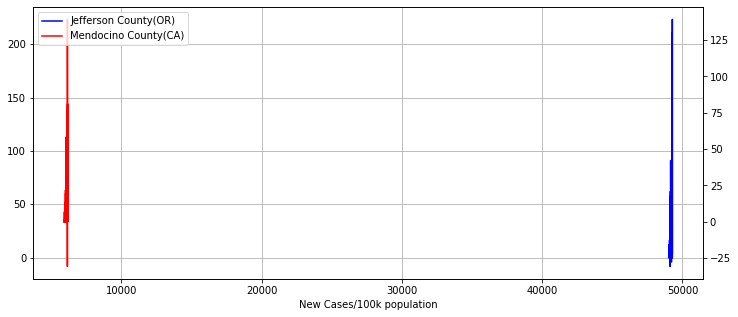

In [ ]:
# TODO
plt.figure(figsize=(12,5))
plt.xlabel('New Cases/100k population')

ax1 = df_jefferson_county["New Cases/100k population"].plot(color='blue', grid=True, label='Jefferson County(OR)')
ax2 = df_Mendocino_county["New Cases/100k population"].plot(color='red', grid=True, secondary_y=True, label='Mendocino County(CA)')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

##### Decisions after Observation and Analysis
* filter each county
* check how each column of demographic is varying - std.dev
* std.dev is zero -> Eg., Pop.Density
* std.dev less -> mean
* std.dev is too high -> we will use worst case like min() or max() 

* **Decisions after Observation and Analysis** :
> * std.dev is zero for these columns: [X..people.older.than.60,Median.income, X..Hispanic.Americans,Employment.density]; Hence taking the columns values as it is.
> * worst case scenerios for these columns [ 'Testing.capacity' (min),'Ventilator.shortage' (?max),'Unemployment.rate'(max),'Unemployment.claims.1000.people'(max)] -#columns that are somewhat related to pandemic
> * Removed Median Income, adding this was causing some issues, all the OR counties were mapping to Santa Clara County only

In [ ]:
or_bin_superset_data_filtered.columns

Index(['FIPS', 'County Name', 'PopDensity', 'X..people.older.than.60',
       'Median.income', 'X..African.Americans', 'X..Hispanic.Americans',
       'X..Male', 'Employment.density', 'Testing.capacity',
       'Ventilator.shortage', 'Unemployment.rate',
       'Unemployment.claims.1000.people'],
      dtype='object')

In [ ]:
or_county_list = or_bin_superset_data_filtered['County Name'].unique()

In [ ]:
print(len(or_knn_df))
or_knn_df.head(2)

32


,PopDensity,X..people.older.than.60,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,Testing.capacity,Ventilator.shortage,Unemployment.rate,Unemployment.claims.1000.people
0,5.013675,26.0,0.9,20.0,51.89,4.0,4.710101,27.081916,9.096906,3.830935
1,0.372079,33.0,0.2,8.0,53.45,1.0,4.699273,24.482247,9.144470,3.957321


In [ ]:
or_knn_df_with_county.head(2)

,FIPS,County Name,PopDensity,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Employment.density,Testing.capacity,Ventilator.shortage,Unemployment.rate,Unemployment.claims.1000.people
0,41031.0,Jefferson County,5.013675,26.0,50339.0,0.9,20.0,51.89,4.0,4.710101,27.081916,9.096906,3.830935
1,41037.0,Lake County,0.372079,33.0,36627.0,0.2,8.0,53.45,1.0,4.699273,24.482247,9.144470,3.957321
